In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
from StockTradingRLEnv_Abhi_copy import StockTradingEnv
import matplotlib.pyplot as plt


In [2]:
# class DQN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 8)
#         self.fc4 = nn.Linear(8, output_dim)
        
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = self.fc4(x)
#         x = torch.nn.functional.softmax(x, dim=-1)
#         return x

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x

In [3]:
class Agent:
    def __init__(self, state_dim, is_eval=False, model_name=""):
        self.state_dim = state_dim
        self.action_dim = 3  # 0: Buy, 1: Sell 2: hold
        self.memory = deque(maxlen=100)
        self.batch_size = 32
        self.gamma = 0.95
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01  # minimum exploration rate
        self.epsilon_decay = 0.999
        self.is_eval = is_eval
        
        self.model = DQN(state_dim, self.action_dim)
        self.target_model = DQN(state_dim, self.action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()
        
        if self.is_eval:
            self.model.load_state_dict(torch.load(f'saved_models/{model_name}'))
        
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, q_values, reward, next_state, done):
        self.memory.append((state, q_values, reward, next_state, done))
        
    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        if not self.is_eval and random.random() <= self.epsilon:
            action = random.randrange(0,self.action_dim)  # 0 for buy, 1 for sell, 2 for hold
            return action, q_values
        print("q_values",q_values)
        action = torch.argmax(q_values[0]).item()
        print("action_type",action)
        return action, q_values
        
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, q_values, reward, next_state, done in minibatch:
            action = torch.argmax(q_values[0]).item()
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = self.model(state).detach().clone()
            if done:
                target[0][action] = reward
            else:
                t = self.target_model(next_state)[0]
                target[0][action] = reward + self.gamma * torch.max(t).item()
            output = self.model(state)
            loss = self.loss_fn(output, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), f'saved_models/{name}.pth')

In [4]:
def plot_buy_sell(env, trades):
    plt.figure(figsize=(15, 7))

    # Plot stock price with a thinner line
    plt.plot(env.df['Date'], env.df['Close'], label='Stock Price', linewidth=1, color='b')

    # Extract buy and sell trades
    buy_trades = [trade for trade in trades if trade[1] == 1]
    sell_trades = [trade for trade in trades if trade[1] == 2]

    plt.scatter(env.df.loc[[trade[0] for trade in sell_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in sell_trades], 'Close'], 
                marker='v', color='r', s=40, label='Sell', alpha=1)
    
    plt.scatter(env.df.loc[[trade[0] for trade in buy_trades], 'Date'], 
                env.df.loc[[trade[0] for trade in buy_trades], 'Close'], 
                marker='^', color='g', s=40, label='Buy', alpha=0.6)


    # Labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Trades')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()
    

In [5]:
def plot_networth(networths):
    plt.figure(figsize=(15, 7))
    plt.plot(networths)
    plt.ylabel('Net Worth')
    plt.title('DQN Trading Bot')
    plt.show()

In [6]:
# df = pd.read_csv('./data/AAPL.csv')
# df = pd.read_csv('./data/^GSPC_2018.csv')
df = pd.read_csv('./data/^GSPC_2010-2015.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.reset_index(drop=True)

env = StockTradingEnv(df, render_mode='human')
state_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
agent = Agent(state_dim=state_dim)

episodes = 10

Time: 0 episode: 1/10 score: 25000
q_values tensor([[6.7468e-03, 1.2482e-04, 9.9313e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.3070e-04, 1.7253e-05, 9.9935e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0795e-04, 8.2210e-06, 9.9978e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[8.9823e-05, 3.9775e-06, 9.9991e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.6150e-05, 2.6307e-06, 9.9993e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[8.1532e-05, 3.5378e-06, 9.9991e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
Time: 100 episode: 1/10 score: 25276.220091999996
q_values tensor([[6.9660e-06, 4.1593e-07, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.3031e-06, 4.2533e-07, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.1760e-06, 2.3861e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.2122e-06, 1.8

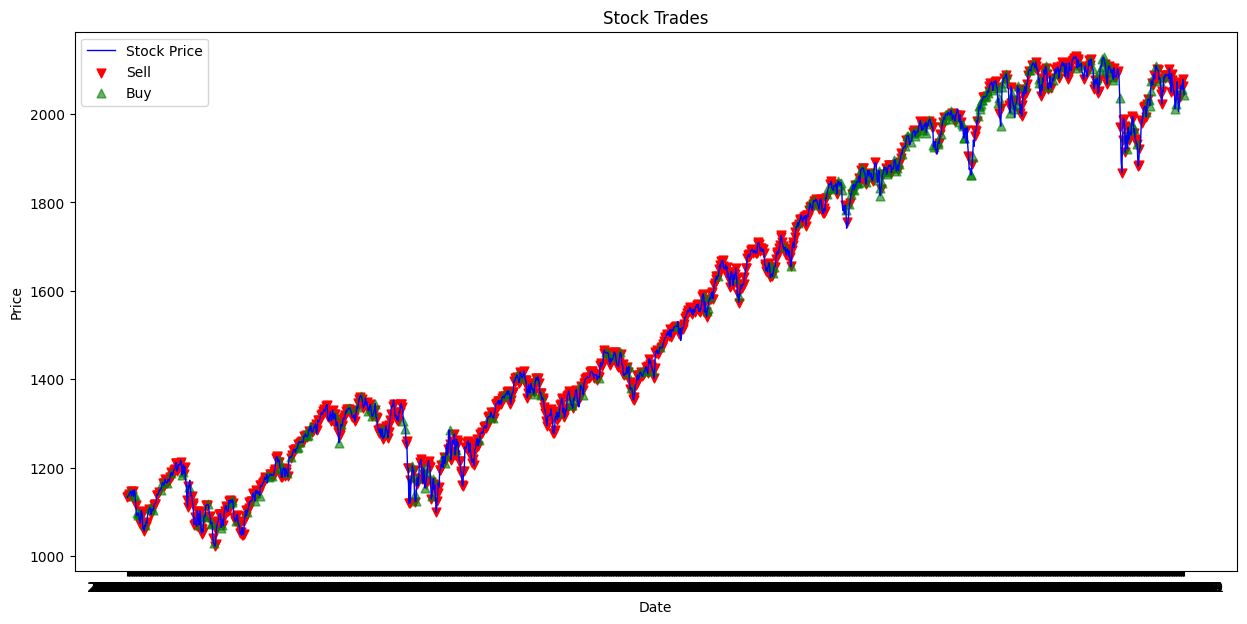

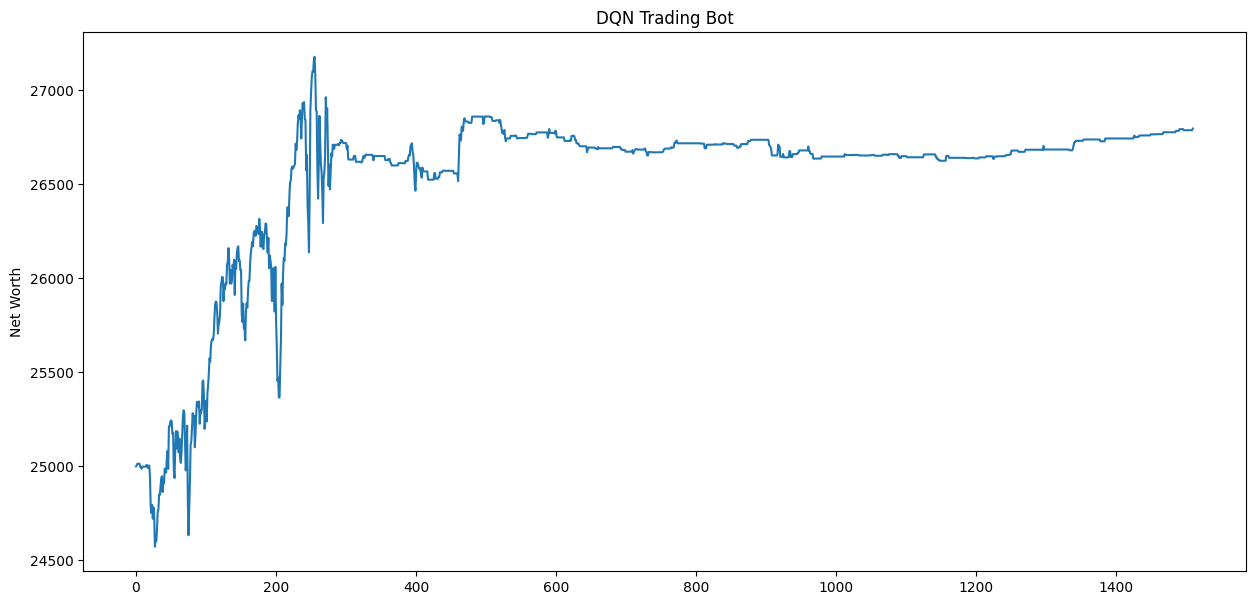

Time: 0 episode: 2/10 score: 25000
q_values tensor([[1.1092e-15, 1.2263e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.9625e-16, 6.5912e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.9606e-16, 6.8737e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[8.8595e-16, 8.8618e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.6857e-15, 1.6625e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.8448e-15, 1.8884e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.5360e-16, 7.6343e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.8569e-16, 4.8331e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.0355e-16, 4.7254e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.6787e-16, 2.3417e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

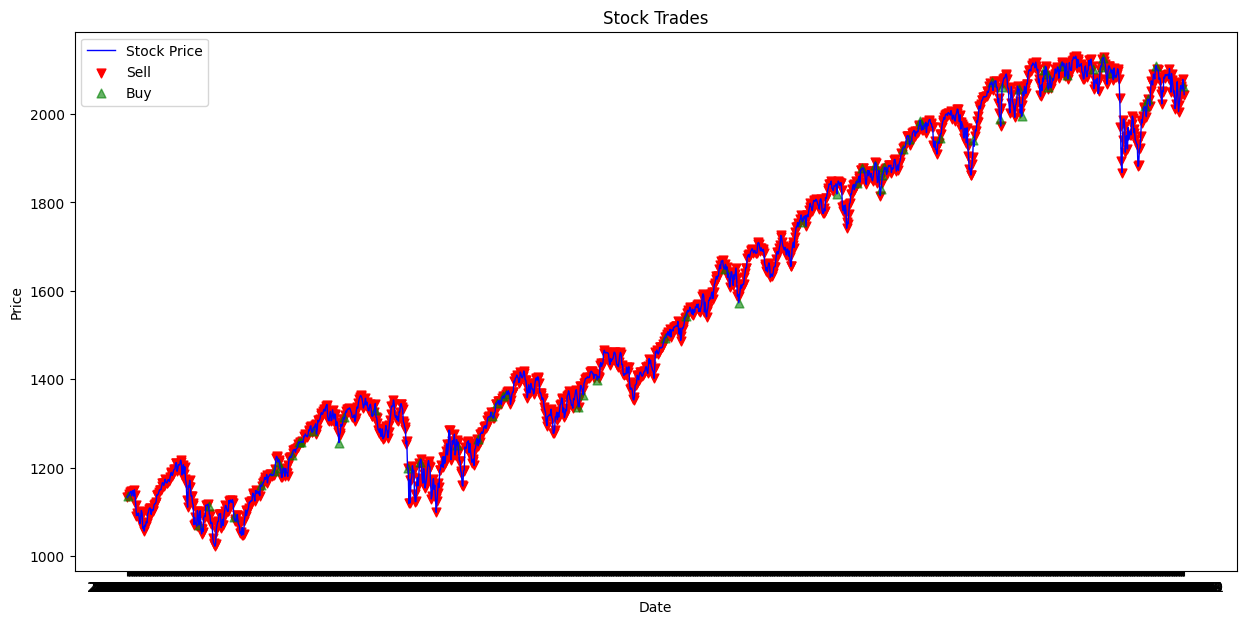

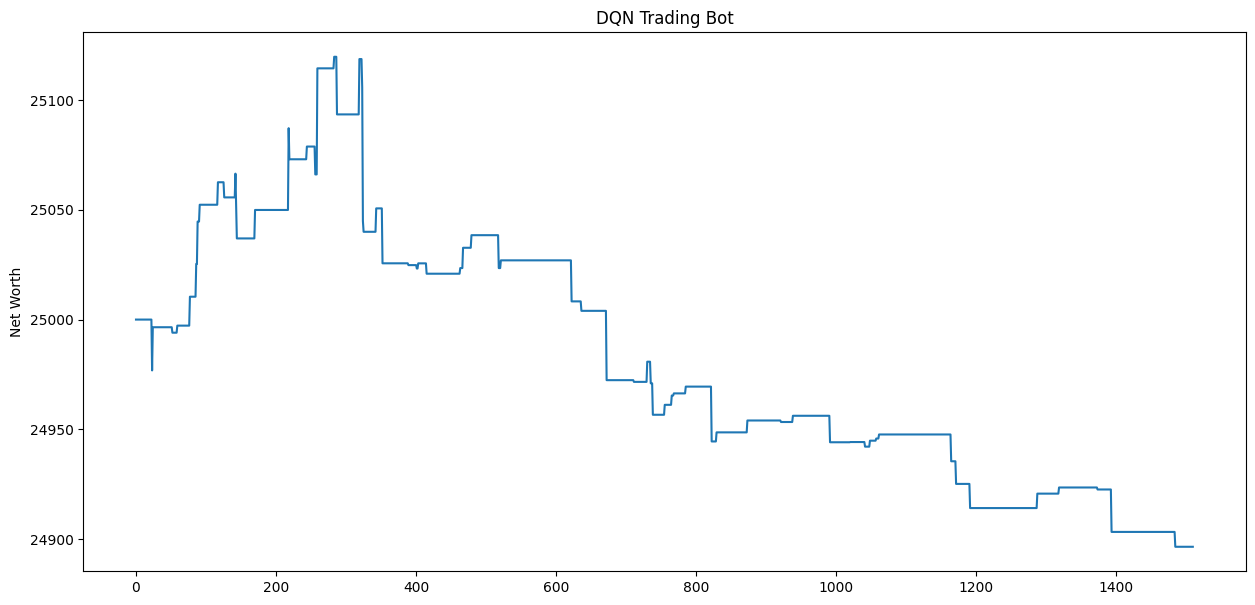

Time: 0 episode: 3/10 score: 25000
q_values tensor([[3.3332e-16, 3.9031e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.1916e-16, 2.5317e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.5752e-16, 2.1857e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.7999e-16, 2.4380e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.7961e-16, 2.1774e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.2541e-16, 2.5864e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.9716e-16, 2.6973e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.7653e-16, 4.4685e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.4056e-16, 4.5400e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.0539e-16, 5.7417e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

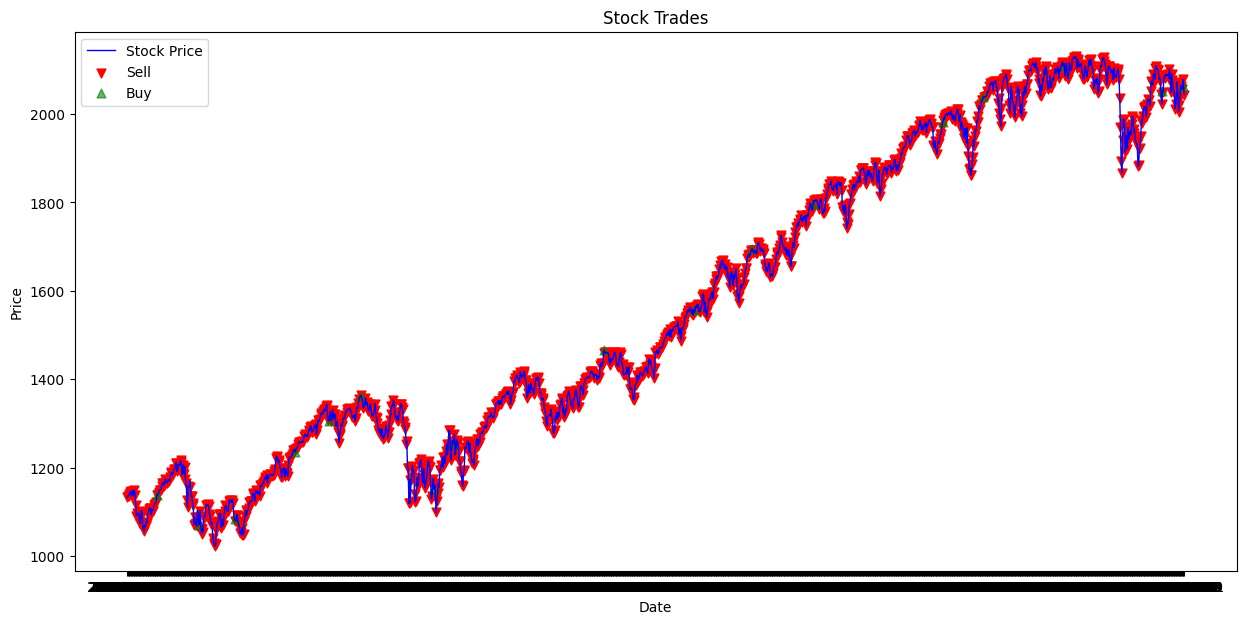

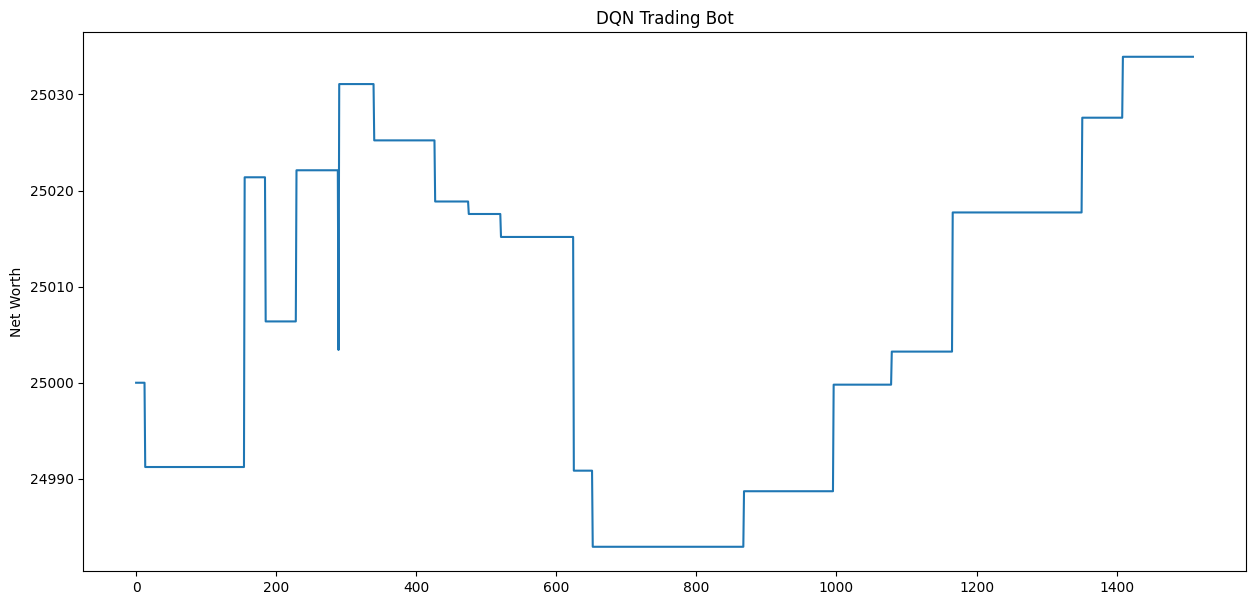

Time: 0 episode: 4/10 score: 25000
q_values tensor([[1.4989e-16, 2.0756e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0630e-16, 2.6520e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.7581e-16, 3.5265e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.1099e-16, 5.0169e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.6940e-16, 6.5631e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[7.0258e-16, 8.3844e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.4383e-15, 1.4004e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[8.9951e-16, 1.0289e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0870e-15, 1.2645e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.9083e-16, 7.6804e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

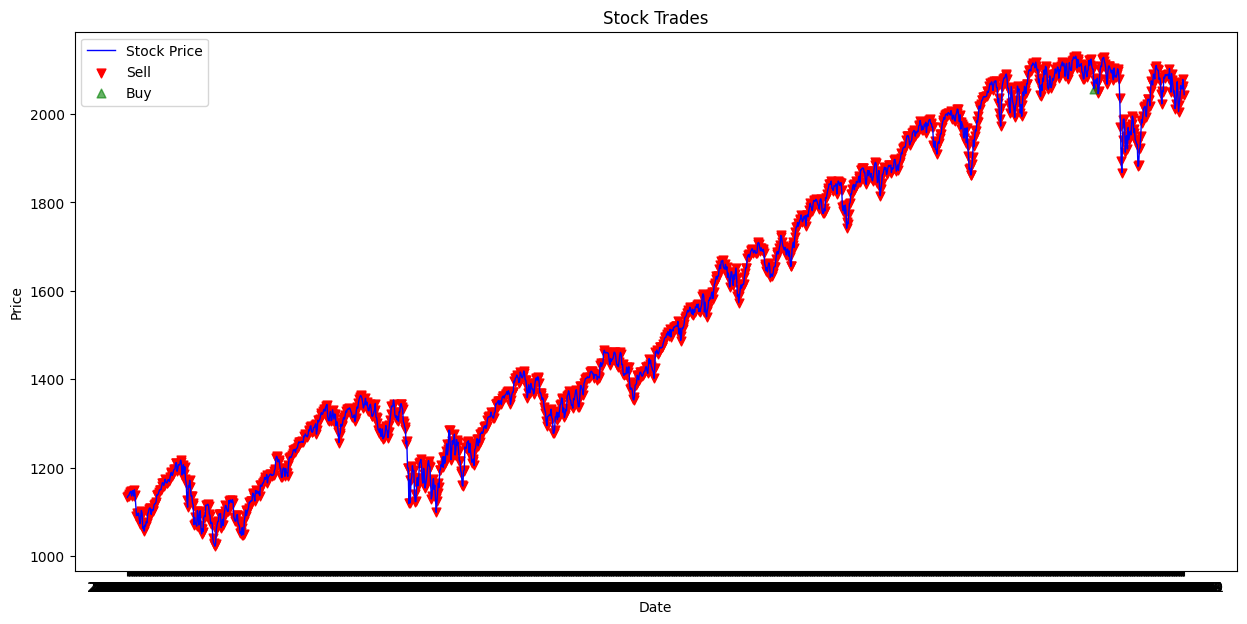

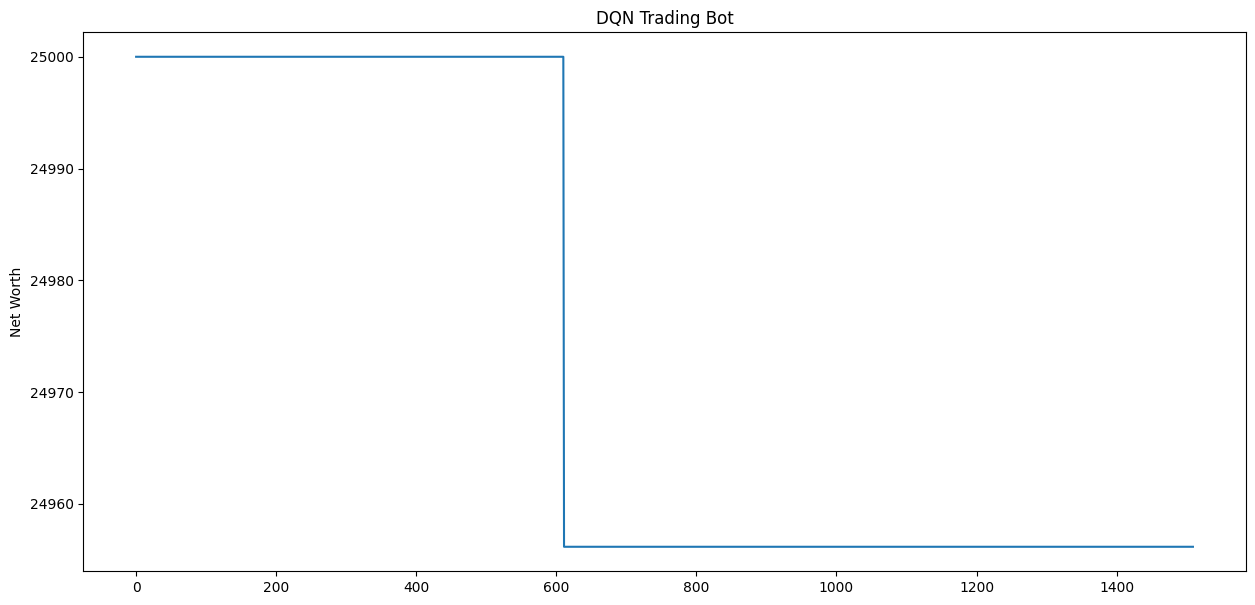

Time: 0 episode: 5/10 score: 25000
q_values tensor([[1.0183e-16, 1.4174e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2089e-16, 1.7042e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.2012e-16, 2.6756e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.6628e-16, 3.0778e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.9971e-16, 2.7718e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0555e-16, 2.6998e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.5169e-16, 2.0382e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.3597e-16, 3.9793e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[7.2973e-16, 7.2582e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.7192e-16, 6.5422e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

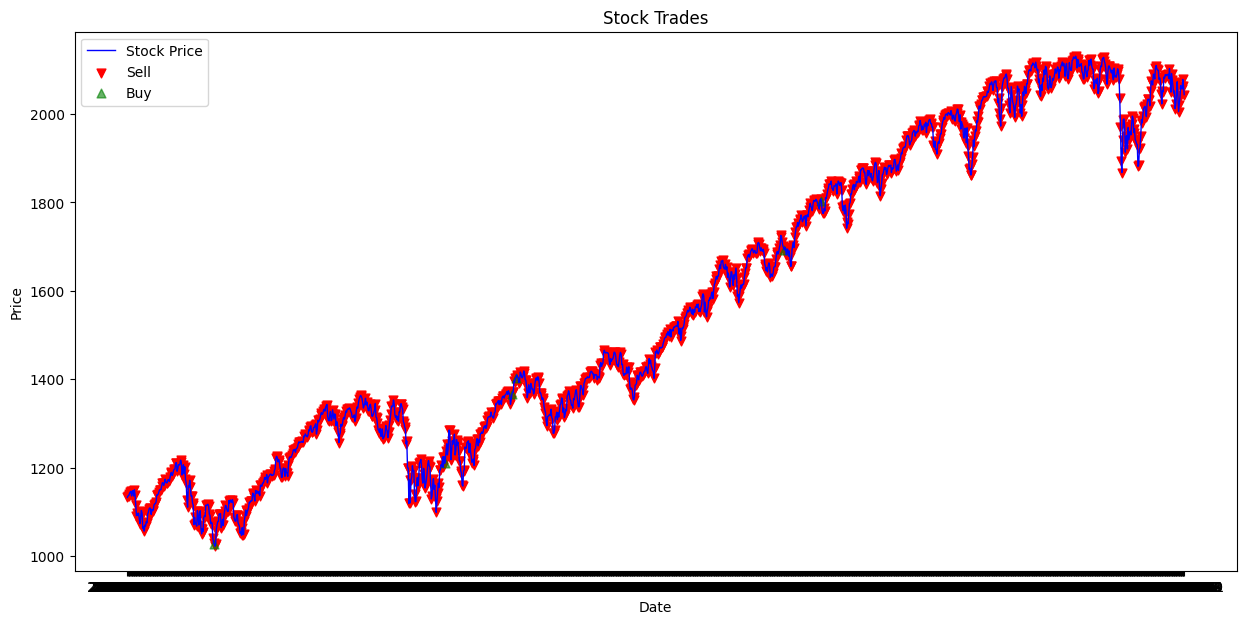

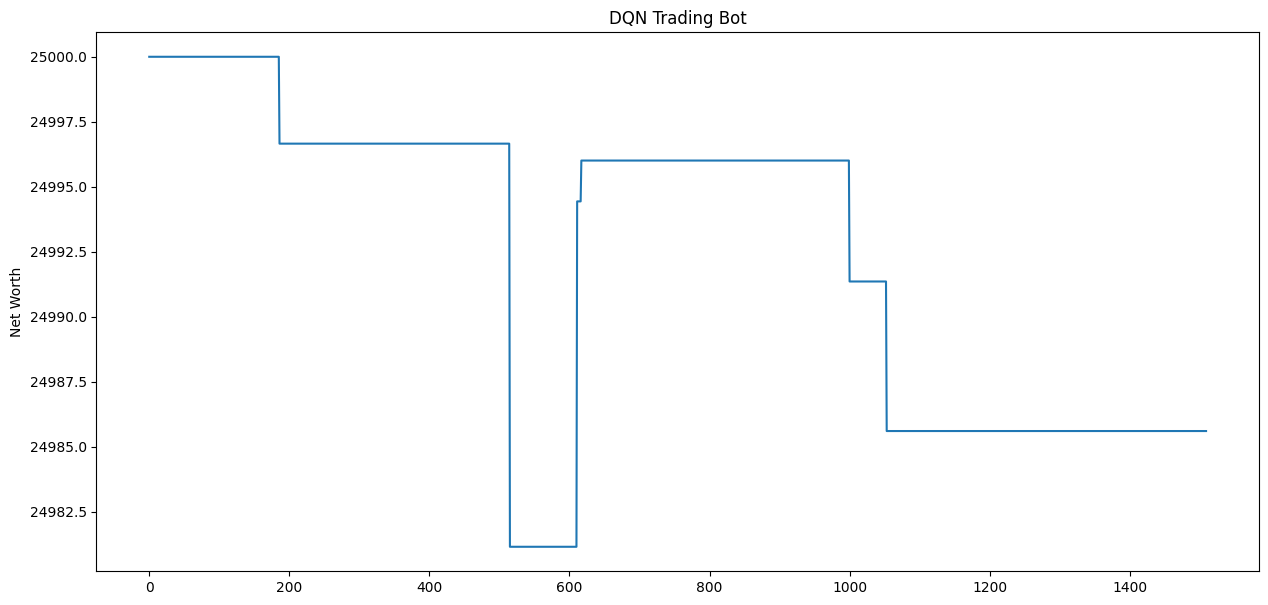

Time: 0 episode: 6/10 score: 25000
q_values tensor([[5.5767e-16, 7.4370e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0646e-15, 1.2737e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0085e-15, 2.0303e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.8096e-15, 2.8344e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.8696e-15, 3.1842e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.9213e-15, 2.2527e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.4217e-15, 1.6042e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2193e-15, 1.4780e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.4608e-15, 2.4480e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.5067e-15, 1.7428e-15, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

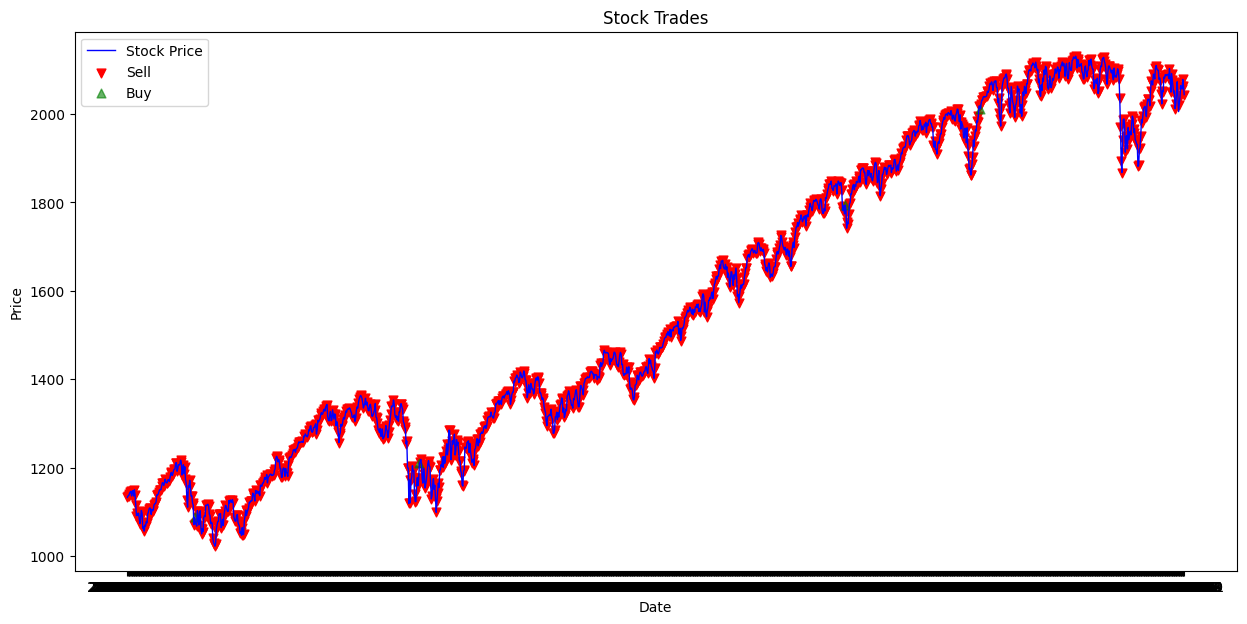

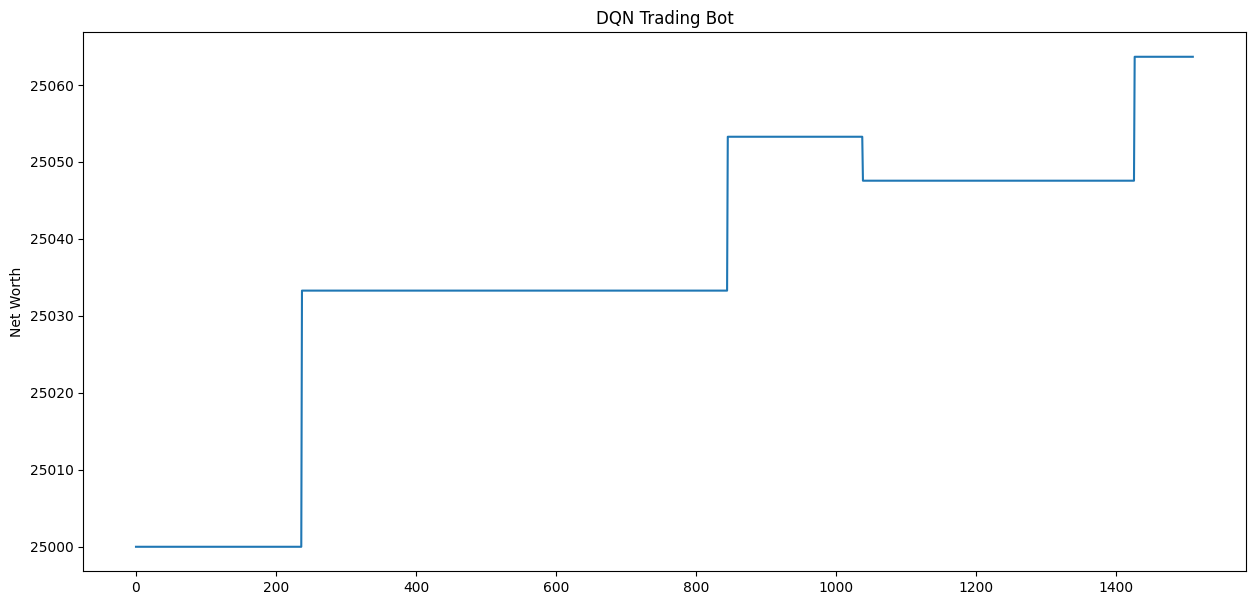

Time: 0 episode: 7/10 score: 25000
q_values tensor([[6.4416e-16, 7.2639e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[7.6374e-16, 8.8164e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.4601e-16, 4.9281e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.1535e-16, 2.9549e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.5576e-16, 4.1368e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.9723e-16, 3.4158e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.9567e-16, 5.8498e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0212e-15, 9.7897e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.4507e-16, 6.1560e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.8188e-16, 5.9594e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

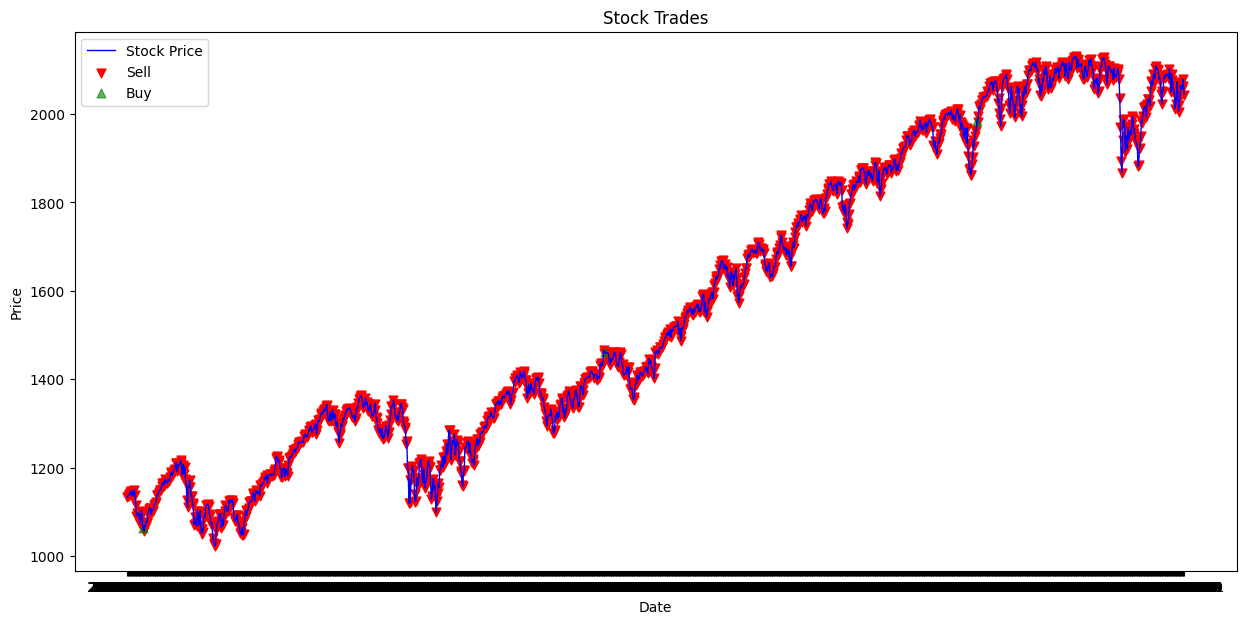

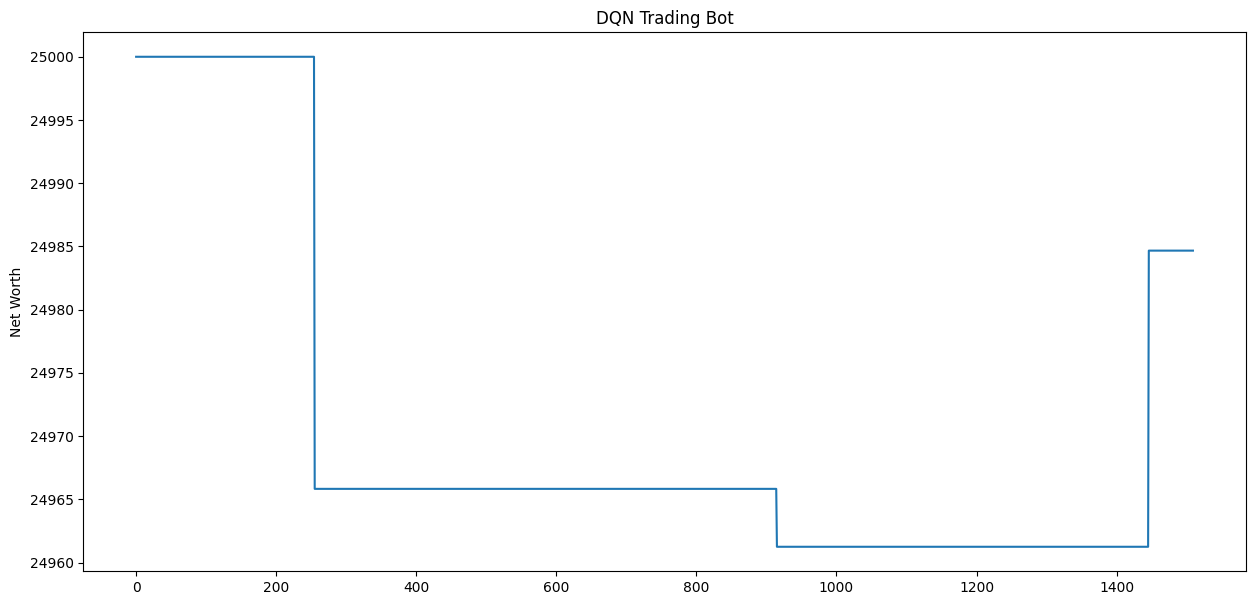

Time: 0 episode: 8/10 score: 25000
q_values tensor([[2.3093e-16, 3.1709e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.4070e-16, 5.2501e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.1551e-16, 5.3318e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.9095e-16, 6.7370e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[7.0235e-16, 8.2774e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.5983e-16, 5.1663e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.7964e-16, 2.5013e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0746e-16, 2.8164e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0907e-16, 2.5414e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.2740e-16, 3.7926e-16, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [7]:
networths = []
for e in range(episodes):
    state = env.reset()
    state = state.flatten()  # Flatten the state to match the input dimensions of the network
    done = False
    trades = []
    networth = []
    for time in range(len(env.df)):
        if(time % 100 == 0):
            print(f"Time: {time} episode: {e+1}/{episodes} score: {env.net_worth}")
        action, q_values = agent.act(state)
        next_state, q_values, reward, done= env.step(action,q_values)
        next_state = next_state.flatten()  # Flatten the next state
        agent.remember(state, q_values, reward, next_state, done)
        state = next_state
        trades.append((env.current_step, action))  # Log the trade action
        if done:
            agent.update_target_model()
            print(f'Episode {e+1}/{episodes} - NetWorth: {env.net_worth}')
            break
        agent.replay()
        networth.append(env.net_worth)
    networths.append(env.net_worth)
    plot_buy_sell(env,trades)
    plot_networth(networth)
    if (e + 1) % 10 == 0:
        agent.save(f"model_dqn_{e+1}")
    agent.save("model_dqn_temp")

[25572.49951, 24478.289063000015, 26922.061273999996, 25589.850096000002, 23601.62964000001, 25467.53003299999, 25179.799324, 24561.669191, 25332.949709000008, 25116.890627000004]


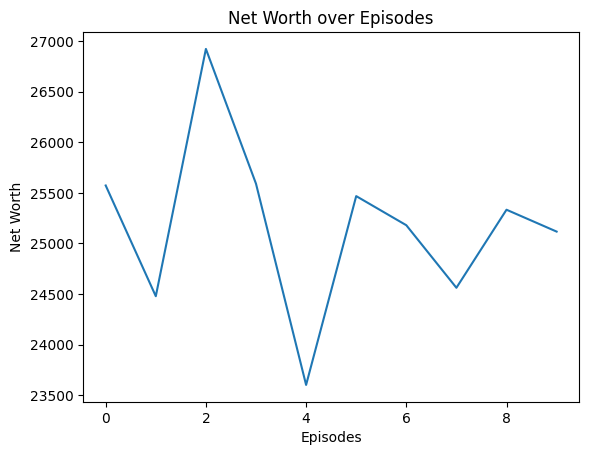

In [ ]:
print(networths)
# Plotting the net worth over episodes
plt.plot(range(episodes), networths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()

Episode: 1/5 Net Worth: 25000
q_values tensor([[4.3107e-10, 1.6196e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.8260e-10, 2.6284e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2259e-09, 2.6164e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2402e-09, 1.3162e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.7337e-10, 1.2562e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.1230e-10, 1.7655e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.6470e-11, 4.8509e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.4694e-11, 5.3646e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.3806e-11, 3.2537e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.9905e-11, 1.1236e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
acti

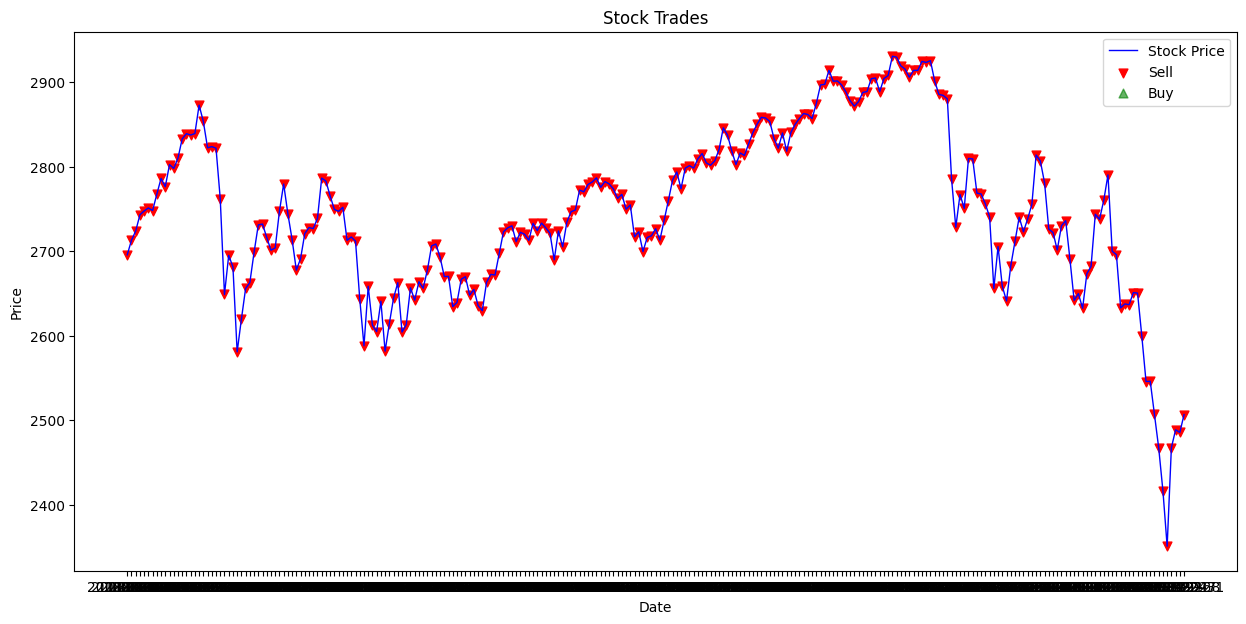

Networths [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0,

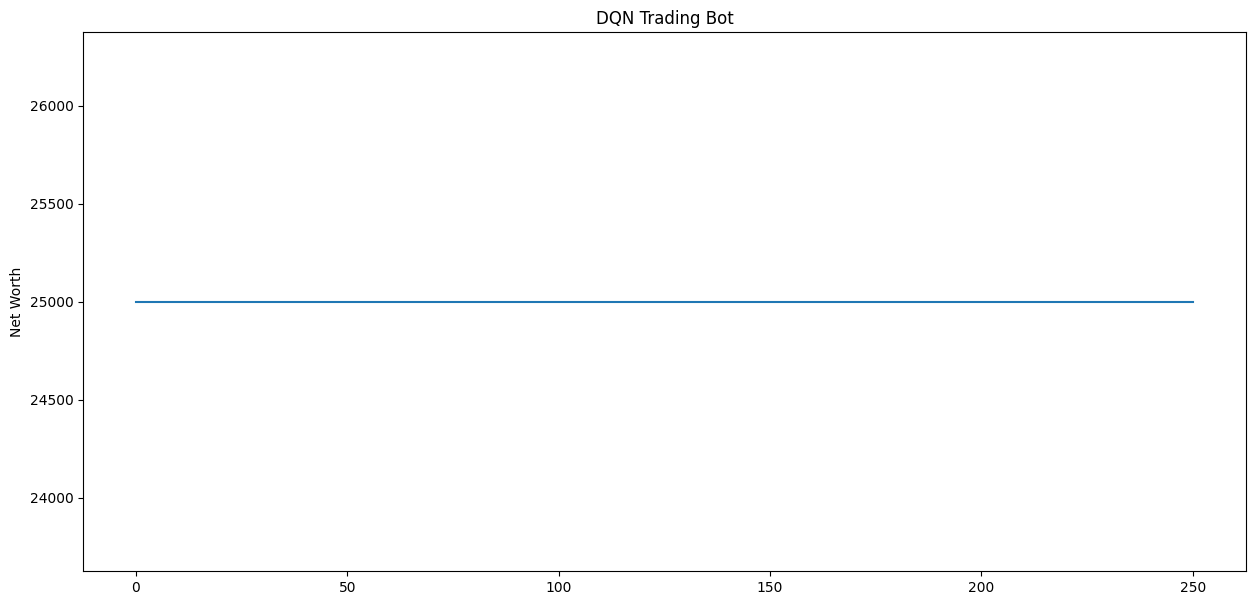

Episode 1/5 - Net Worth: 25000.0
Episode: 2/5 Net Worth: 25000
q_values tensor([[2.6179e-10, 2.2042e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.2522e-10, 3.8514e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2601e-09, 1.6158e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2819e-09, 3.4828e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.3386e-10, 1.2481e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.1485e-11, 5.9263e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.9309e-12, 1.2314e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.1215e-12, 4.6748e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0437e-11, 3.9477e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.6102e-11, 3.6649e-07, 1.0000e+00]],

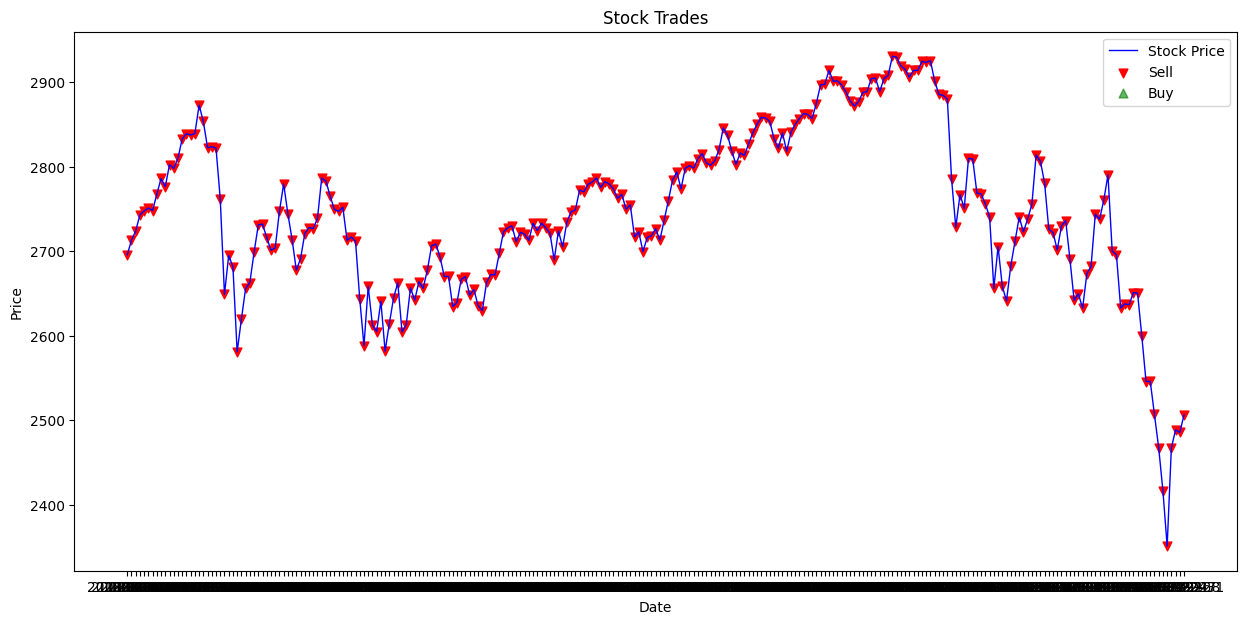

Networths [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0,

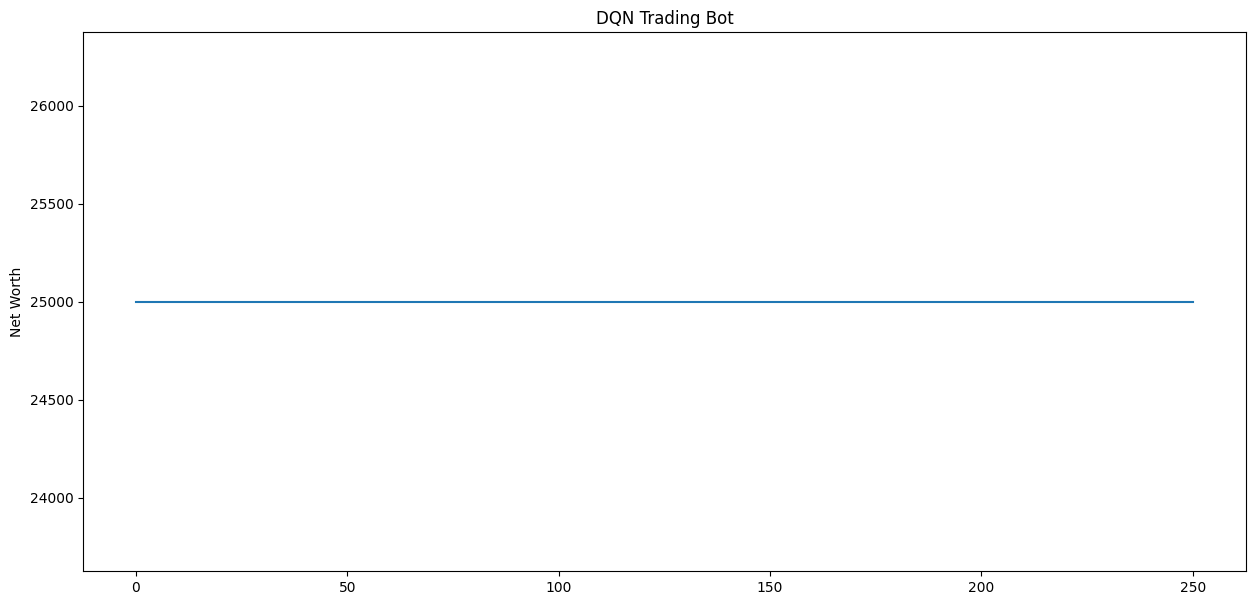

Episode 2/5 - Net Worth: 25000.0
Episode: 3/5 Net Worth: 25000
q_values tensor([[2.2522e-10, 3.8514e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2601e-09, 1.6158e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2819e-09, 3.4828e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.3386e-10, 1.2481e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.1485e-11, 5.9263e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.9309e-12, 1.2314e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.1215e-12, 4.6748e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0437e-11, 3.9477e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.6102e-11, 3.6649e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.3860e-10, 2.3354e-08, 1.0000e+00]],

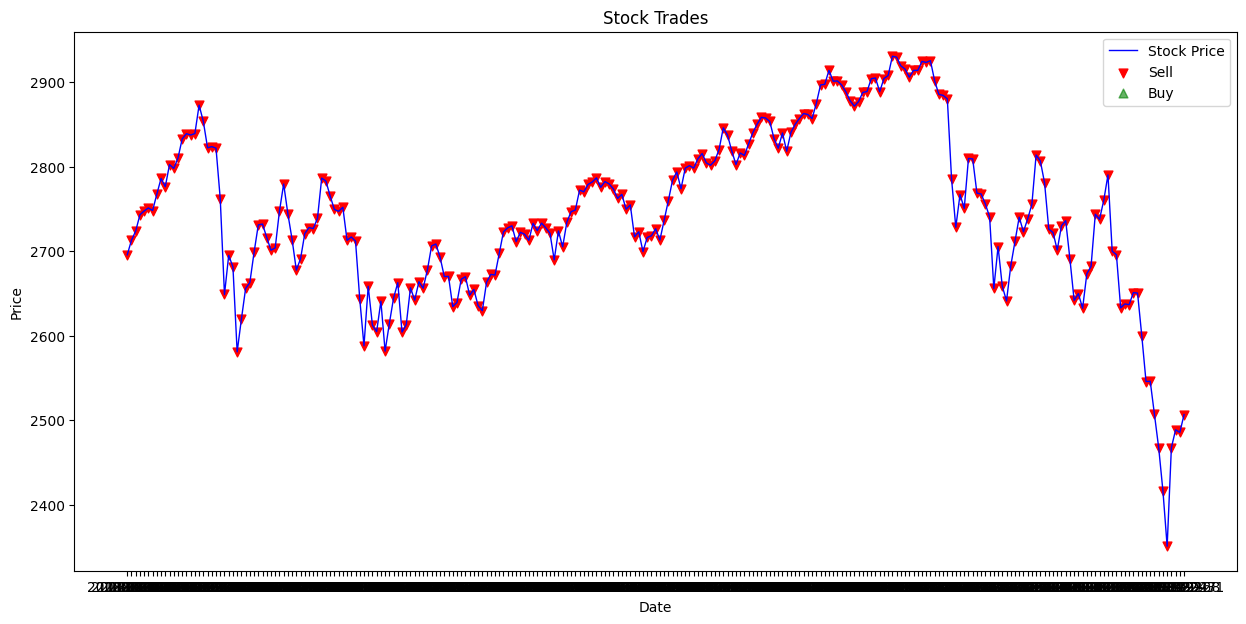

Networths [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0,

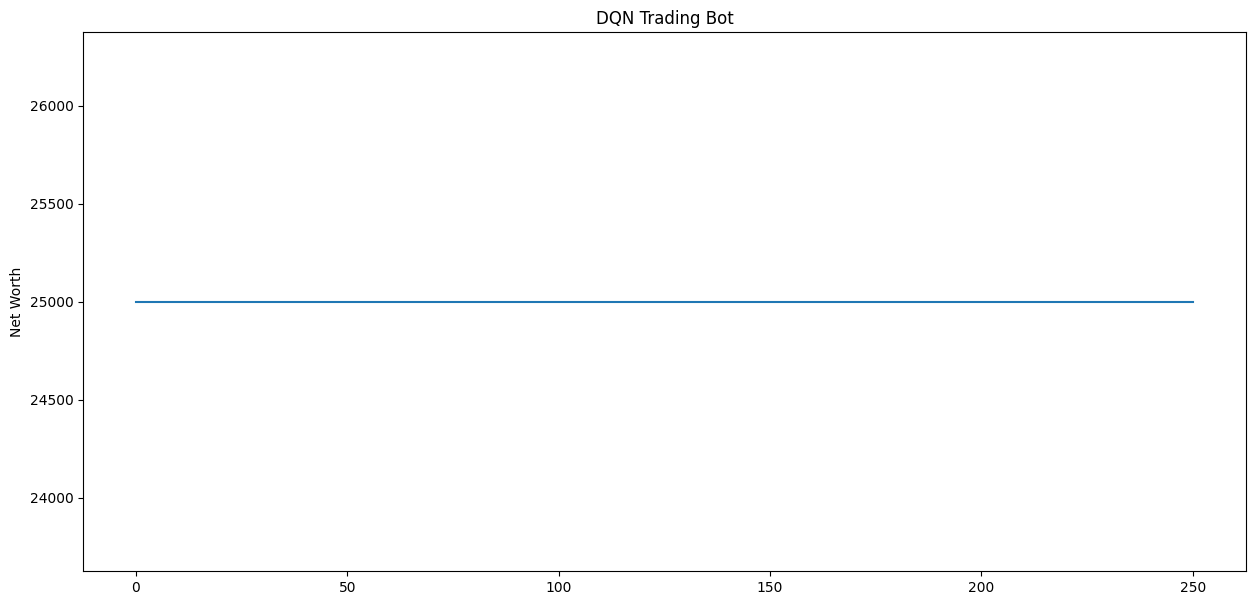

Episode 3/5 - Net Worth: 25000.0
Episode: 4/5 Net Worth: 25000
q_values tensor([[4.2964e-10, 2.0641e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.3452e-11, 9.4042e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[9.1918e-13, 7.4462e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.7077e-12, 2.3411e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.0060e-12, 1.5031e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[6.9641e-12, 7.4628e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0609e-10, 2.8661e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.3170e-10, 6.4406e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.6311e-11, 6.0843e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.0287e-11, 3.8902e-07, 1.0000e+00]],

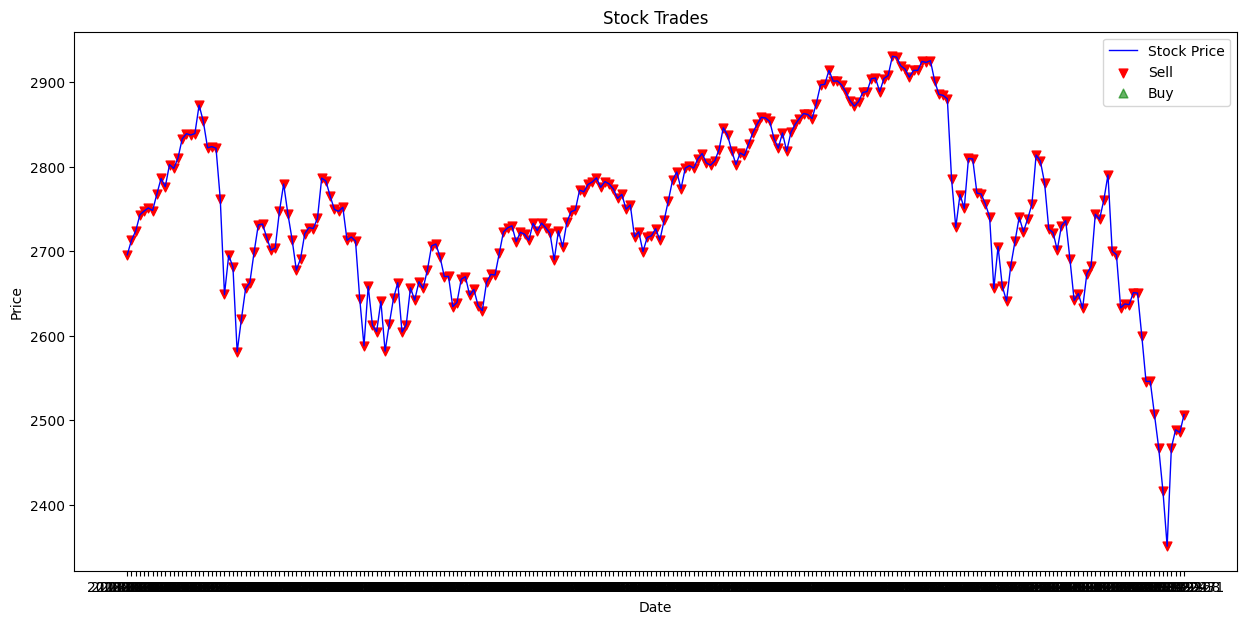

Networths [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0,

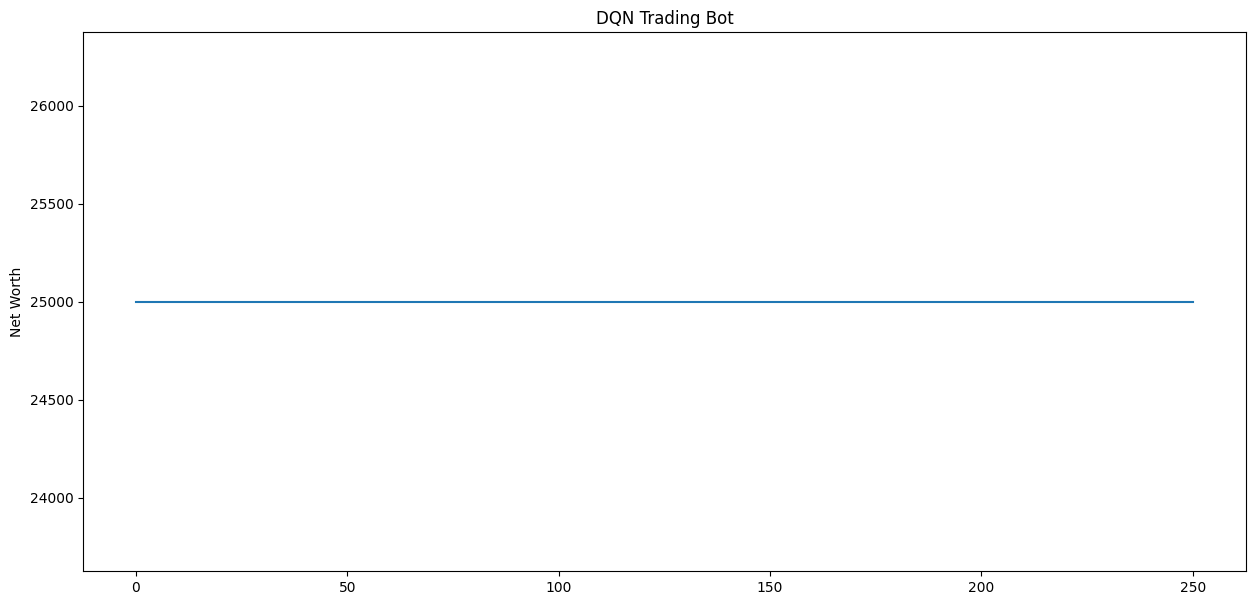

Episode 4/5 - Net Worth: 25000.0
Episode: 5/5 Net Worth: 25000
q_values tensor([[5.6889e-10, 1.4381e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[4.9556e-11, 6.7029e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.9618e-12, 1.4011e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.5320e-12, 2.6885e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.2088e-11, 3.0412e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.7341e-11, 3.5613e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[5.9839e-10, 2.2887e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[1.5144e-10, 2.8212e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[2.4080e-10, 1.3675e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
action_type 2
q_values tensor([[3.1317e-11, 9.8310e-07, 1.0000e+00]],

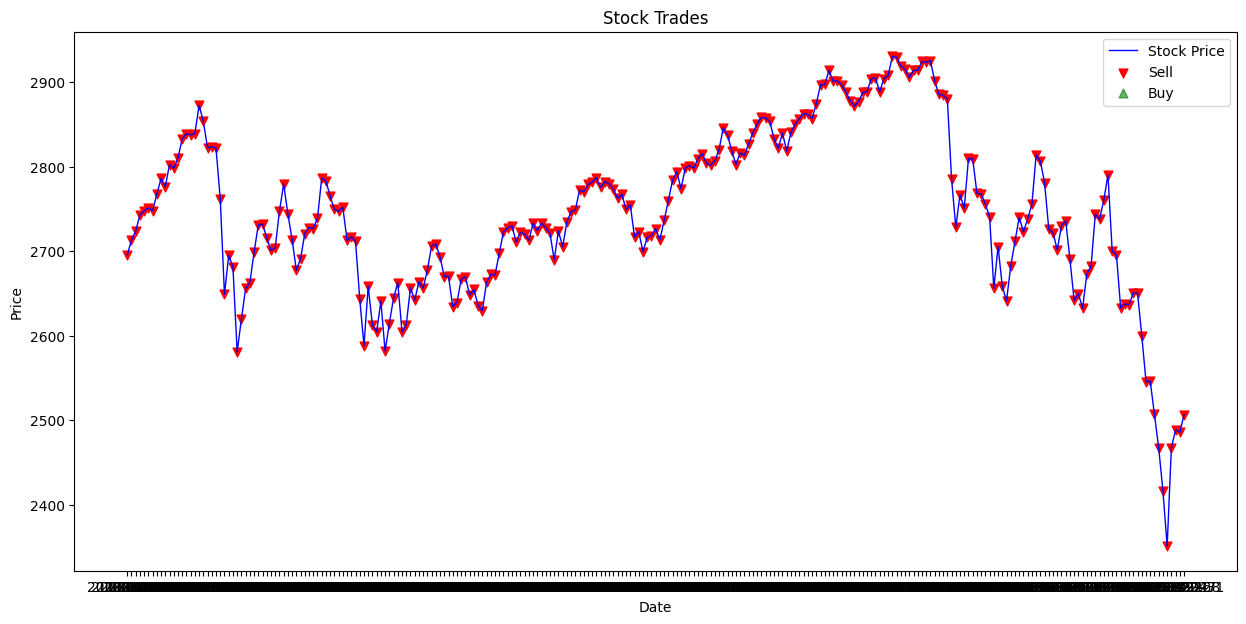

Networths [25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0, 25000.0,

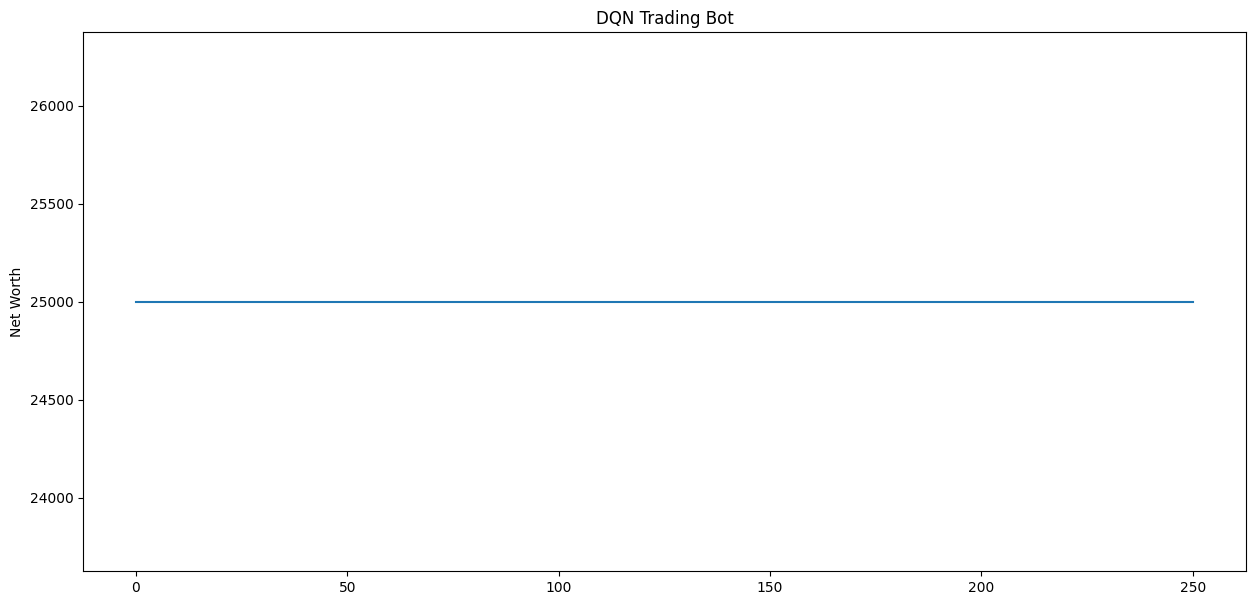

Episode 5/5 - Net Worth: 25000.0
Average net worth over 5 episodes: 25000.0


In [ ]:
# Evaluation
def evaluate(env, agent, episodes=5):
    # total_rewards = 0
    final_networths = []
    for e in range(episodes):
        trades = []
        state = env.reset()
        state = state.flatten()
        networths = []
        print(f"Episode: {e+1}/{episodes} Net Worth: {env.net_worth}")
        for time in range(len(env.df)):
            action, q_values = agent.act(state)
            next_state, q_values, reward, done= env.step(action, q_values)
            # print("action",action)
            trades.append((env.current_step, action))  # Log the trade action
            next_state = next_state.flatten()
            # total_rewards += reward
            state = next_state
            if done:
                break
            networths.append(env.net_worth)
        plot_buy_sell(env,trades)
        print("Networths",networths)
        plot_networth(networths)
        final_networths.append(env.net_worth)
        print(f'Episode {e+1}/{episodes} - Net Worth: {env.net_worth}')
        
    print(f"Average net worth over {episodes} episodes: {sum(final_networths)/episodes}")
    

# Evaluate the agent
# agent = Agent(state_dim=state_dim)
agent = Agent(state_dim=state_dim,is_eval=True, model_name="model_dqn_temp.pth")
evaluate(env, agent)
# plt.savefig('saved_visuals/dqn_eval1.jpeg')